In [25]:
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# -------- paths --------
DATA_CSV = Path("/Users/joycex/Desktop/Housing price project/data/cleaned/panel_wide.csv")
OUT_DIR = Path("/Users/joycex/Desktop/Housing price project/Phase2/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

DATA_CSV, OUT_DIR


(PosixPath('/Users/joycex/Desktop/Housing price project/data/cleaned/panel_wide.csv'),
 PosixPath('/Users/joycex/Desktop/Housing price project/Phase2/outputs'))

In [26]:
# Load panel data (Sydney + Melbourne quarterly panel)
df = pd.read_csv(DATA_CSV)

# Make sure quarter behaves well in formulas
df["quarter"] = df["quarter"].astype(str)

# Keep only the columns we actually use
cols_keep = [
    "state", "quarter",
    "ln_rppi",
    "cash_rate_level", "nom_AUS",
    "ln_approvals", "completion_rate_nat",
    "ln_population", "unemp_rate",
    "rate_x_supply_gap",
]

df = df[cols_keep].copy()

# Sort for time-series operations
df = df.sort_values(["state", "quarter"]).reset_index(drop=True)

df.head()



,state,quarter,ln_rppi,cash_rate_level,nom_AUS,ln_approvals,completion_rate_nat,ln_population,unemp_rate,rate_x_supply_gap
0,NSW,2008Q1,4.665324,7.125000,NaN,8.892337,NaN,15.749913,4.513072,-48.860231
1,NSW,2008Q2,4.669084,NaN,NaN,8.998013,NaN,15.753311,4.572727,NaN
2,NSW,2008Q3,4.650144,7.000000,NaN,8.851520,NaN,15.757469,4.830858,-48.341643
3,NSW,2008Q4,4.647271,5.166667,226130.0,8.801168,NaN,15.761675,5.305880,-35.962619
4,NSW,2009Q1,4.618086,3.250000,299190.0,8.466952,NaN,15.766042,5.964020,-23.722042


In [27]:
# ---------------------------
# 1. Fixed-effects model (levels)
# ln_rppi on macro drivers + state / quarter dummies
# ---------------------------

fe_data = df.dropna(subset=[
    "ln_rppi",
    "cash_rate_level", "nom_AUS",
    "ln_approvals", "completion_rate_nat",
    "ln_population", "unemp_rate",
    "rate_x_supply_gap",
])

fe_formula = """
ln_rppi ~ cash_rate_level + nom_AUS
          + ln_approvals + completion_rate_nat
          + ln_population + unemp_rate
          + rate_x_supply_gap
          + C(state) + C(quarter)
"""

fe_model = smf.ols(formula=fe_formula, data=fe_data)

# Use HC1 (heteroskedasticity-robust) standard errors
fe_res = fe_model.fit(cov_type="HC1")
print(fe_res.summary())



                            OLS Regression Results                            
Dep. Variable:                ln_rppi   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.169e+05
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           4.74e-31
Time:                        11:17:39   Log-Likelihood:                 91.158
No. Observations:                  36   AIC:                            -136.3
Df Residuals:                      13   BIC:                            -99.89
Df Model:                          22                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.5875 

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 22
  warnings.warn('covariance of constraints does not have full '


In [28]:
# ---------------------------
# 2. Build first differences for DL / ARDL models
# ---------------------------

group_cols = ["state"]

df_dl = df.sort_values(["state", "quarter"]).copy()

# Level variables
df_dl["ln_rppi"] = df_dl["ln_rppi"]

# First differences by state
df_dl["d_ln_rppi"]           = df_dl.groupby(group_cols)["ln_rppi"].diff()
df_dl["d_cash_rate_level"]   = df_dl.groupby(group_cols)["cash_rate_level"].diff()
df_dl["d_nom_AUS"]           = df_dl.groupby(group_cols)["nom_AUS"].diff()
df_dl["d_ln_approvals"]      = df_dl.groupby(group_cols)["ln_approvals"].diff()
df_dl["d_completion_rate_nat"] = df_dl.groupby(group_cols)["completion_rate_nat"].diff()
df_dl["d_ln_population"]     = df_dl.groupby(group_cols)["ln_population"].diff()
df_dl["d_unemp_rate"]        = df_dl.groupby(group_cols)["unemp_rate"].diff()
df_dl["d_rate_x_supply_gap"] = df_dl.groupby(group_cols)["rate_x_supply_gap"].diff()

# Drop first quarters where the diff is missing
dl_vars = [
    "state", "quarter",
    "d_ln_rppi",
    "d_cash_rate_level", "d_nom_AUS",
    "d_ln_approvals", "d_completion_rate_nat",
    "d_ln_population", "d_unemp_rate",
    "d_rate_x_supply_gap",
]

dl_data = df_dl[dl_vars].dropna().copy()
dl_data.head()


,state,quarter,d_ln_rppi,d_cash_rate_level,d_nom_AUS,d_ln_approvals,d_completion_rate_nat,d_ln_population,d_unemp_rate,d_rate_x_supply_gap
8,NSW,2010Q1,0.051078,0.500,77690.0,0.019897,0.153022,0.003774,-0.292383,-3.276119
9,NSW,2010Q2,0.048596,0.375,-95000.0,-0.028693,-0.371653,0.002233,-0.244845,-2.634715
22,NSW,2013Q3,0.035639,-0.250,45380.0,0.170555,-0.017321,0.003623,0.219496,2.031464
29,NSW,2015Q2,0.085552,-0.250,-108600.0,0.082902,-0.051705,0.002687,-0.192216,1.702199
34,NSW,2016Q3,0.025358,-0.250,107190.0,0.156414,-0.041981,0.004523,-0.132986,1.726169


In [29]:
# ---------------------------
# 3. Distributed-lag style model in differences
#    Interpreted as short-run responses of ∆ln(price)
# ---------------------------

dl_formula = """
d_ln_rppi ~ d_cash_rate_level + d_nom_AUS
            + d_ln_approvals + d_completion_rate_nat
            + d_ln_population + d_unemp_rate
            + d_rate_x_supply_gap
            + C(state) + C(quarter)
"""

dl_model = smf.ols(formula=dl_formula, data=dl_data)
dl_res = dl_model.fit(cov_type="HC1")
print(dl_res.summary())


                            OLS Regression Results                            
Dep. Variable:              d_ln_rppi   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     793.1
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           6.56e-05
Time:                        11:18:04   Log-Likelihood:                 62.105
No. Observations:                  16   AIC:                            -98.21
Df Residuals:                       3   BIC:                            -88.17
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.30

/opt/anaconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  warnings.warn('covariance of constraints does not have full '


In [30]:
# ---------------------------
# 4. Extract core coefficients + p-values
#    (drop intercept and dummies)
# ---------------------------

core_vars = [
    "cash_rate_level", "nom_AUS",
    "ln_approvals", "completion_rate_nat",
    "ln_population", "unemp_rate",
    "rate_x_supply_gap",
]

def signif_code(p: float) -> str:
    """Return standard significance stars based on p-value."""
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.10:
        return "*"
    return ""

# FE table
fe_coef = fe_res.params[core_vars]
fe_se   = fe_res.bse[core_vars]
fe_p    = fe_res.pvalues[core_vars]

fe_table = pd.DataFrame({
    "Variable": core_vars,
    "FE_coef": fe_coef.values,
    "FE_se": fe_se.values,
    "FE_pval": fe_p.values,
    "Sig": [signif_code(p) for p in fe_p.values],
})

# DL short-run table
dl_core_vars = [
    "d_cash_rate_level", "d_nom_AUS",
    "d_ln_approvals", "d_completion_rate_nat",
    "d_ln_population", "d_unemp_rate",
    "d_rate_x_supply_gap",
]

dl_coef = dl_res.params[dl_core_vars]
dl_se   = dl_res.bse[dl_core_vars]
dl_p    = dl_res.pvalues[dl_core_vars]

dl_table = pd.DataFrame({
    "Variable": dl_core_vars,
    "DL_coef": dl_coef.values,
    "DL_se": dl_se.values,
    "DL_pval": dl_p.values,
    "Sig": [signif_code(p) for p in dl_p.values],
})

fe_table, dl_table.head()


(              Variable   FE_coef     FE_se   FE_pval Sig
 0      cash_rate_level -0.200070  0.553601  0.717803    
 1              nom_AUS  0.000010  0.000015  0.531817    
 2         ln_approvals  0.100523  0.109061  0.356677    
 3  completion_rate_nat  2.145733  3.613330  0.552620    
 4        ln_population -0.415376  1.181479  0.725159    
 5           unemp_rate -0.025007  0.041328  0.545125    
 6    rate_x_supply_gap  0.018567  0.034163  0.586790    ,
                 Variable       DL_coef         DL_se   DL_pval Sig
 0      d_cash_rate_level  3.599133e-01  2.409201e-01  0.135199    
 1              d_nom_AUS  9.393645e-07  5.263352e-07  0.074306   *
 2         d_ln_approvals -1.470327e-01  1.254946e-01  0.241347    
 3  d_completion_rate_nat  6.498390e-02  3.458088e-02  0.060219   *
 4        d_ln_population -8.724474e+01  4.460069e+01  0.050450   *)

In [31]:
# Save tables for use in the written report
fe_out_csv = OUT_DIR / "TABLE_FE_core_summary.csv"
dl_out_csv = OUT_DIR / "TABLE_DL_core_summary.csv"

fe_table.to_csv(fe_out_csv, index=False)
dl_table.to_csv(dl_out_csv, index=False)

print("Saved FE table to :", fe_out_csv)
print("Saved DL table to :", dl_out_csv)


Saved FE table to : /Users/joycex/Desktop/Housing price project/Phase2/outputs/TABLE_FE_core_summary.csv
Saved DL table to : /Users/joycex/Desktop/Housing price project/Phase2/outputs/TABLE_DL_core_summary.csv


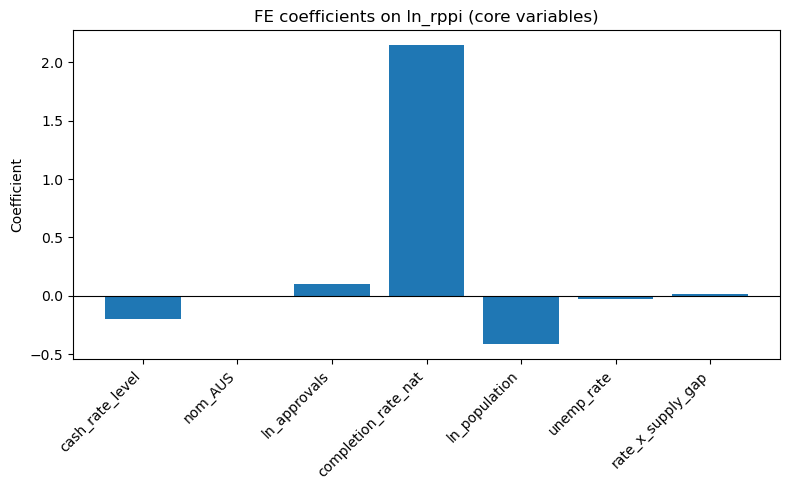

Saved FE figure to: /Users/joycex/Desktop/Housing price project/Phase2/outputs/FIG_FE_core_coeffs.png


In [32]:
# ---------------------------
# 5. Simple bar chart of FE coefficients (core variables)
# ---------------------------

plot_df = fe_table.copy()

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(plot_df["Variable"], plot_df["FE_coef"])
ax.axhline(0, color="black", linewidth=0.8)

ax.set_title("FE coefficients on ln_rppi (core variables)")
ax.set_ylabel("Coefficient")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

fig_path = OUT_DIR / "FIG_FE_core_coeffs.png"
plt.savefig(fig_path, dpi=300)
plt.show()

print("Saved FE figure to:", fig_path)
